# Estimating Extreme Risks and Dependence of Stock Indices
#### Research Project for the Course Quantitative Risk Management
Authors: **Nicolo Giacopelli & Oskar Girardin**

## I – Empirical/descriptive analysis

In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from scipy.stats import norm, kurtosis, skew
from itertools import combinations
from collections import defaultdict
from statsmodels.distributions.copula.api import StudentTCopula
import pycopula

# Define colors of graphs
DARK_COL = "#6876a4"
DARK_COL = "#138086"
LIGHT_COL = "#f0b64d"
sns.set_style("whitegrid")

# Function to get tickers of S&P 500
tickers_indeces = ["^GSPC", "^GDAXI", "^FTSE"]

In [2]:
# Download data from 1987 to end of 2022
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2022, 12, 31)
data = yf.download(tickers_indeces, start = start, end = end)
prices = data["Adj Close"]

# Rename columns
prices = prices.rename({"^GSPC": "SP500", "^GDAXI": "DAX", "^FTSE": "FTSE"}, axis = 1)

prices

[*********************100%***********************]  3 of 3 completed


,FTSE,DAX,SP500
Date,,,
1987-01-02,1681.099976,NaN,246.449997
1987-01-05,1680.000000,NaN,252.190002
1987-01-06,1690.699951,NaN,252.779999
1987-01-07,1722.199951,NaN,255.330002
1987-01-08,1733.099976,NaN,257.279999
...,...,...,...
2022-12-23,7473.000000,13940.929688,3844.820068
2022-12-27,NaN,13995.099609,3829.250000
2022-12-28,7497.200195,13925.599609,3783.219971


### 1. Show the plot of the daily prices, $p_i$ of the S&P 500, then describe what you see

In [3]:
def plot_time_series(df, col_name, ylab = 'Price (in US $)', title = None, xlab = "Date"):
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df.index, df[col_name], color = DARK_COL)

    # Set the axis labels and title
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(False)
    # Show the plot
    plt.show()

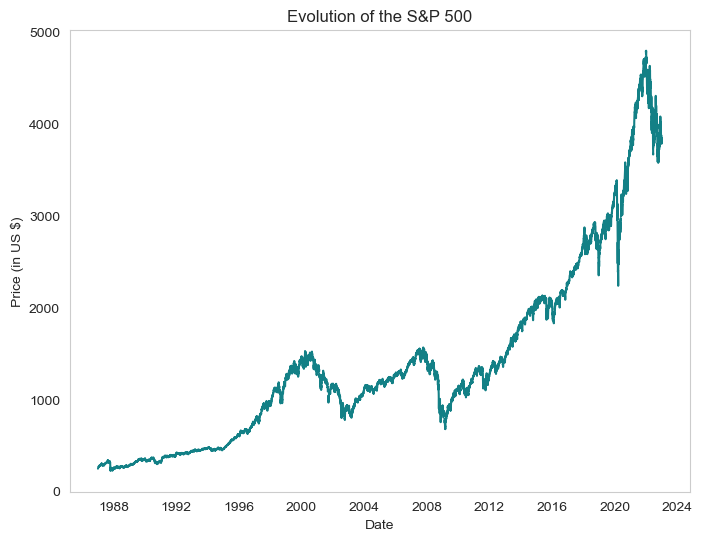

In [4]:
plot_time_series(prices, "SP500", title="Evolution of the S&P 500")

### 2. Transform your three data sets to consider now the daily log return: $$x_i = \log p_i - \log p_{i-1}$$ and give a plot of this new data set (x_i, i = 1,...,n) for the S&P 500. What do you notice? Why did we perform this transformation? We consider the obtained returns as realization of three random variables (rv)’s: $U$ the rv for the S&P 500 returns, $V$ the rv for the FTSE returns, and $W$ the rv for the DAX.

In [5]:
def to_log_returns(prices: pd.Series):
    log_prices = np.log(prices)
    prices_diff = log_prices.diff()
    return prices_diff

In [6]:
returns = prices.apply(to_log_returns, axis = 0)

In [7]:
returns

,FTSE,DAX,SP500
Date,,,
1987-01-02,NaN,NaN,NaN
1987-01-05,-0.000655,NaN,0.023024
1987-01-06,0.006349,NaN,0.002337
1987-01-07,0.018460,NaN,0.010037
1987-01-08,0.006309,NaN,0.007608
...,...,...,...
2022-12-23,0.000495,0.001929,0.005851
2022-12-27,NaN,0.003878,-0.004058
2022-12-28,NaN,-0.004978,-0.012093


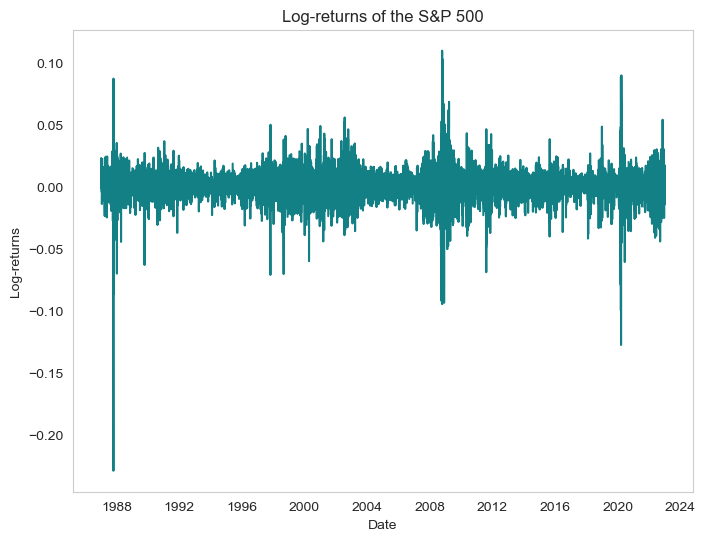

In [8]:
plot_time_series(returns, "SP500", ylab="Log-returns", title= "Log-returns of the S&P 500")

### 3. Present your empirical analysis done on these later data sets in two tables, one for the basic statistics containing: 
1. Descriptive statistics (number of observations, $\mu$, $\sigma$, skewness, kurtosis) 
2. Rank statistics (Maximum, Median, Minimum)

In [9]:
def compute_stats(df):
    moment_functions = ["count", "mean", "std", "skew", "kurt", "min", "median", "max"]
    return df.agg(moment_functions)

In [10]:
basic_stats = compute_stats(returns)
basic_stats

,FTSE,DAX,SP500
count,8899.000000,8668.000000,8855.000000
mean,0.000135,0.000238,0.000311
std,0.011145,0.013956,0.011799
skew,-0.570827,-0.295273,-1.208194
kurt,10.467729,6.780182,25.841746
min,-0.130286,-0.140912,-0.228997
median,0.000500,0.000736,0.000607
max,0.093842,0.107975,0.109572


In [11]:
def _get_risk_measure_df(df, method, alpha):
    if method == "VaR":
        return pd.Series(np.quantile(df.dropna(), q = alpha, axis = 0), index = df.columns)
    elif method == "tVaR":
        return df[df > np.quantile(df.dropna(), q = alpha, axis = 0)].mean()
    else:
        return -1
    
def _get_risk_measure_series(series, method, alpha):
    if method == "VaR":
        return np.quantile(series.dropna(), q = alpha)
    elif method == "tVaR":
        return series[series > np.quantile(series.dropna(), q = alpha, axis = 0)].mean()
    else:
        return -1

def get_risk_measure(x, method, alpha):
    return _get_risk_measure_df(x, method, alpha) if isinstance(x, pd.DataFrame) else _get_risk_measure_series(x, method, alpha)


In [12]:
alpha_var = 0.995
alpha_tvar = 0.99
# Define losses as negative returns
losses = -returns
# Get VAR at 99.5%
VAR = get_risk_measure(losses, "VaR", alpha_var)
# Get tVAR at 99%
tVAR = get_risk_measure(losses, "tVaR", alpha_tvar)
# Get VAR and tVAR using gaussian model
means = basic_stats.loc["mean", :]
stds = basic_stats.loc["std", :]
VAR_gaussian = stds*norm.ppf(alpha_var) + means
tVAR_gaussian = stds*(norm.pdf(norm.ppf(alpha_tvar)))/(1-alpha_tvar) + means
# Combine into one dataframe
risk_measures = pd.DataFrame([VAR, VAR_gaussian, tVAR, tVAR_gaussian], index = ["VAR_empirical", "VAR_gaussian", "tVAR_empirical", "tVAR_gaussian"])
risk_measures

,FTSE,DAX,SP500
VAR_empirical,0.037493,0.050432,0.040792
VAR_gaussian,0.028842,0.036186,0.030703
tVAR_empirical,0.044349,0.054378,0.050077
tVAR_gaussian,0.029839,0.037434,0.031758


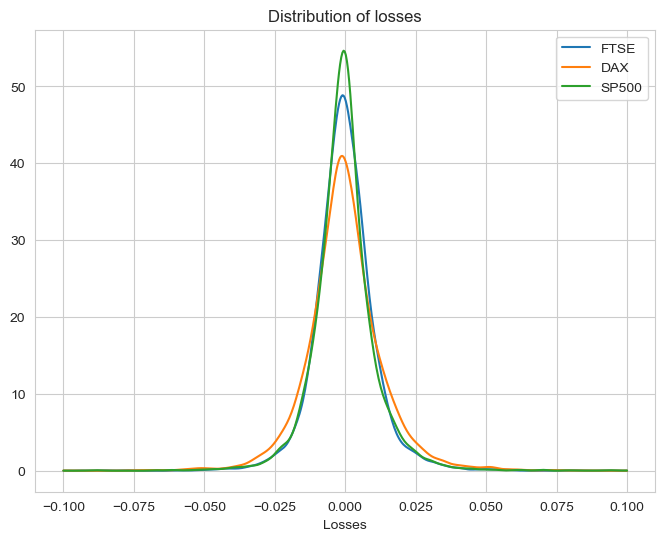

In [13]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(3):
    values = losses.iloc[:,i].dropna()
    d = stats.gaussian_kde(values)
    ind = np.linspace(-0.1, 0.1, 500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label=losses.columns[i])

# Set the axis labels and title
plt.xlabel("Losses")
plt.title("Distribution of losses")
plt.legend()
# Show the plot
plt.show()

### e. Build a portfolio, $Z = U + V + W$, with the three indices and compute the empirical VaR of the losses at 99.5% and the TVaR at 99%. Allocate the capital according to: $C(L|P) = \mathbb{E}[L] - \mathbb{E}[L|Z \leq F_Z^{-1}(\alpha)]$, to the three indices in the portfolio.

In [14]:
# We consider only time periods where all three indices are available
losses_sync = losses.dropna()
Z = losses_sync.mean(axis = 1)

In [15]:
# Compute risk measures for Z
VaR_Z = get_risk_measure(Z, "VaR", alpha_var)
tVaR_Z = get_risk_measure(Z, "tVaR", alpha_tvar)
print(f"Risk measures of portfolio:\nVaR: {VaR_Z: .4f}\ntVaR: {tVaR_Z: .4f}")

Risk measures of portfolio:
VaR:  0.0387
tVaR:  0.0426


In [16]:
# Compute capital allocated without risky part
mean_losses = losses_sync.mean(axis = 0)
capital_alloc = np.mean(losses_sync, axis = 0) - np.mean(losses_sync[Z <= VaR_Z], axis = 0)

In [17]:
# Compute capital allocated with risky part (kind of ES of portfolio)
capital_alloc2 = np.mean(losses_sync[Z >= VaR_Z], axis = 0) - np.mean(losses_sync, axis = 0)

In [18]:
capital_alloc

FTSE     0.000238
DAX      0.000292
SP500    0.000259
dtype: float64

In [19]:
capital_alloc2

FTSE     0.046565
DAX      0.057122
SP500    0.050759
dtype: float64

### f. Diversification benefits

In [20]:
def get_div_benefits(C_X_P, C_X):
    return 1 - C_X_P/C_X

def get_C_X(losses):
    return get_risk_measure(losses, "VaR", alpha_var) - losses.mean(axis = 0)

def get_C_X2(losses):
    return losses.mean(axis = 0) - np.mean(losses_sync[losses_sync <= VAR], axis = 0)


In [21]:
VAR

FTSE     0.037493
DAX      0.050432
SP500    0.040792
dtype: float64

In [22]:
losses_sync[losses_sync <= VAR]

,FTSE,DAX,SP500
Date,,,
1988-01-06,0.001398,-0.009900,-0.001005
1988-01-07,-0.000056,-0.008374,-0.008385
1988-01-08,0.007752,-0.011974,NaN
1988-01-11,0.007471,0.038898,-0.016664
1988-01-12,0.012002,0.000638,0.008399
...,...,...,...
2022-12-21,-0.017044,-0.015236,-0.014759
2022-12-22,0.003742,0.013120,0.014557
2022-12-23,-0.000495,-0.001929,-0.005851


In [23]:
C_X = get_C_X2(losses)
C_X

FTSE     0.000223
DAX      0.000301
SP500    0.000294
dtype: float64

In [24]:
get_div_benefits(capital_alloc, C_X)

FTSE    -0.064767
DAX      0.031470
SP500    0.117410
dtype: float64

### e. RoRAC

In [25]:
returns_sync = returns.dropna()

In [26]:
mean_returns = returns_sync.mean()
mean_returns

FTSE     0.000095
DAX      0.000219
SP500    0.000300
dtype: float64

In [27]:
yearly_returns = mean_returns * 252
yearly_VaR = VAR * np.sqrt(252)
yearly_tVaR = tVAR * np.sqrt(252)

In [28]:
yearly_returns

FTSE     0.023832
DAX      0.055074
SP500    0.075593
dtype: float64

In [29]:
rorac_standalone_VaR = yearly_returns/yearly_VaR
rorac_standalone_tVaR = yearly_returns/yearly_tVaR
print(f"VaR\n{rorac_standalone_VaR}\n------------------\ntVaR\n{rorac_standalone_tVaR}")

VaR
FTSE     0.040040
DAX      0.068791
SP500    0.116738
dtype: float64
------------------
tVaR
FTSE     0.033850
DAX      0.063800
SP500    0.095091
dtype: float64


In [30]:
# RoRAC portfolio
yearly_return_Z = (-Z).mean() * 252
yearly_VaR_Z = VaR_Z * np.sqrt(252)
yearly_tVaR_Z = tVaR_Z * np.sqrt(252)
rorac_Z = yearly_return_Z/pd.Series([yearly_VaR_Z, yearly_tVaR_Z], index = ["VaR", "tVaR"])
rorac_Z

VaR     0.083858
tVaR    0.076184
dtype: float64

In [31]:
# RoRAC indeces in portfolio based on capital allocated looking at ES of portfolio
yearly_returns / yearly_VaR_Z

FTSE     0.038805
DAX      0.089677
SP500    0.123090
dtype: float64

## III. Bivariate analyis

### Draw the ranked scatter plot for the three pairs, do you see a difference?

In [32]:
ftse = losses_sync["FTSE"]
dax = losses_sync["DAX"]
sp500 = losses_sync["SP500"]


def plot_rankscatter(series1, series2, ax, title = None):
    ranks1 = stats.rankdata(series1)
    ranks2 = stats.rankdata(series2)

    ax.scatter(ranks1, ranks2, s = 2, color = DARK_COL)
    ax.grid(False)
    ax.set_xlabel(series1.name)
    ax.set_ylabel(series2.name)
    ax.set_title(title)

def plot_rankscatters():
    fig, axs = plt.subplots(ncols=3, figsize = (20, 6))
    for i, (x, y) in enumerate(combinations([ftse, dax, sp500], r = 2)):
        ranks_x = stats.rankdata(x)
        ranks_y = stats.rankdata(y)
        cor_spearman = stats.spearmanr(x, y)
        axs[i].scatter(ranks_x, ranks_y, s = 2, color = DARK_COL)
        axs[i].grid(False)
        axs[i].set_xlabel(x.name)
        axs[i].set_ylabel(y.name)
        axs[i].set_title(f"{x.name} & {y.name} (Spearman: {cor_spearman.statistic: .2f})")
    plt.show()

In [33]:
#plot_rankscatter(ftse, dax)

In [34]:
#plot_rankscatter(ftse, sp500)

In [35]:
#plot_rankscatter(sp500, dax)

### Compute the Spearman and the Pearson correlation, what do you obtain?

In [36]:
# Spearman and Pearson coefficients
def get_correlations(*series_list):
    # Get all combinations of 2 elements in series_list
    combs = combinations(list(series_list), r = 2)
    res = pd.DataFrame(np.zeros((len(list(series_list)), 2)), columns=["Spearman", "Pearson"])
    # Get the names of the elements for indexing the final dataframe
    combs_names = combinations(list(series_list), r = 2)
    combs_names = [(x.name, y.name) for x, y in list(combs_names)]
    res = res.reindex(combs_names)
    # Compute correlations for every combination
    for i, (x, y) in enumerate(combs):
        cor_spearman = stats.spearmanr(x, y)
        cor_pearson = stats.pearsonr(x, y)
        res.iloc[i] = [cor_spearman.statistic, cor_pearson.statistic]
    return res

In [37]:
np.corrcoef(np.array([sp500, dax, ftse]))

array([[1.        , 0.53395368, 0.51696021],
       [0.53395368, 1.        , 0.7646622 ],
       [0.51696021, 0.7646622 , 1.        ]])

In [38]:
def get_correlations(*series_list):
    names = [x.name for x in list(series_list)]
    print("Spearman correlation")
    corrs_spearman = stats.spearmanr(np.array([sp500, dax, ftse]).transpose()).statistic
    df_corrs_spearman = pd.DataFrame(corrs_spearman, columns = names, index = names)
    print(df_corrs_spearman)
    
    print("-----------------------------------")
    print("Pearson correlation")
    corrs_pearson = np.corrcoef(np.array([sp500, dax, ftse]))
    df_corrs_pearson = pd.DataFrame(corrs_pearson, columns = names, index = names)
    print(df_corrs_pearson)
    return df_corrs_spearman, df_corrs_pearson

In [39]:
df_corrs_spearman, df_corrs_pearson = get_correlations(sp500, dax, ftse)

Spearman correlation
          SP500       DAX      FTSE
SP500  1.000000  0.454312  0.440810
DAX    0.454312  1.000000  0.713209
FTSE   0.440810  0.713209  1.000000
-----------------------------------
Pearson correlation
          SP500       DAX      FTSE
SP500  1.000000  0.533954  0.516960
DAX    0.533954  1.000000  0.764662
FTSE   0.516960  0.764662  1.000000


### Suggest copulas to model dependence and fit them to your data

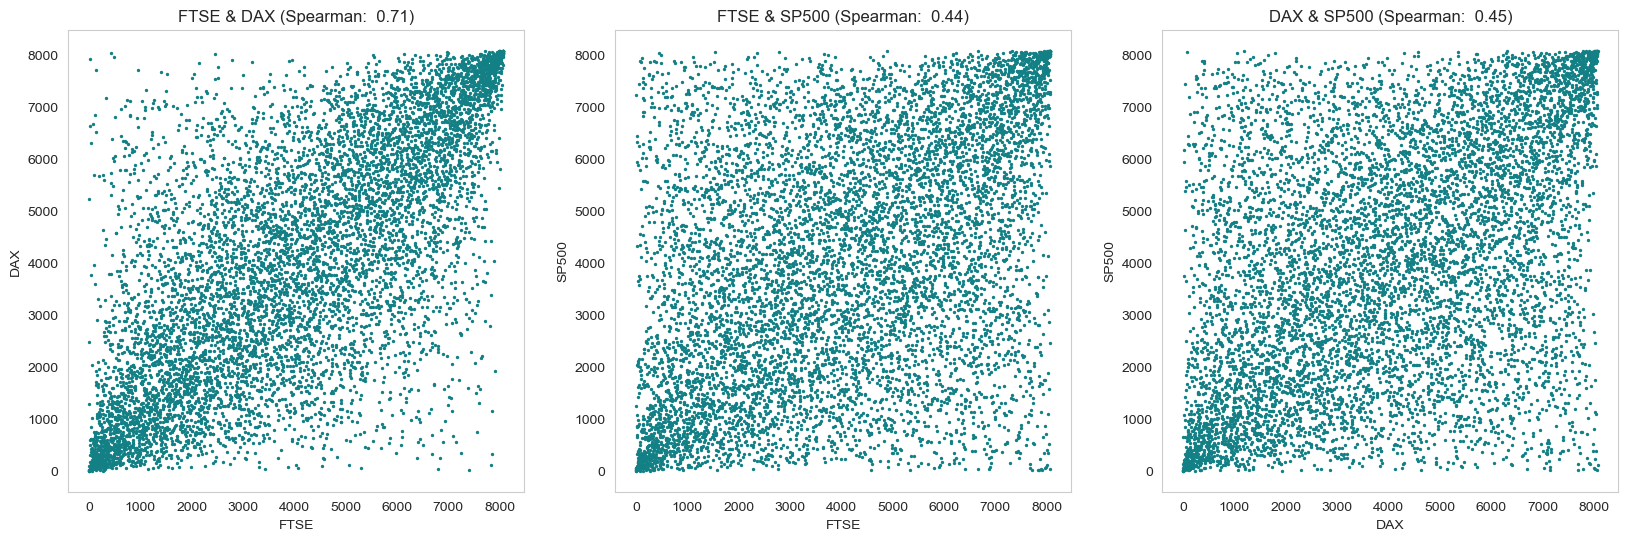

In [40]:
plot_rankscatters()

Available choices: *Clayton, survival Clayton, Gumbel, Student, Gaussian*\
\
Clayton, survival clayton always can be ruled out (dependence on both sides).
1. FTSE & DAX: **Student-t** (off-diagonal elements in matrix around 0.8, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), some outliers in top-left and bottom-right corners (no Gauss)
2. FTSE & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)
3. DAX & S&P 500: **Student-t** (off-diagonal elements in matrix around 0.5-0.6, deg. of freedoms of around 7-9)\
Symmetric (no Gumbel), a lot of outliers in top-left and bottom-right corners (no Gauss)


In [41]:
# Fit FTSE & DAX
corr_ftse_dax = df_corrs_spearman["FTSE"]["DAX"]
R1 = np.full((2,2), corr_ftse_dax)
np.fill_diagonal(R1, 1)
student_copula = StudentTCopula(R1, 4)

In [42]:
student_copula.df

4

In [43]:
def plot_copula(ax_plot, ax_none, rho = 0.8, deg_freedom = 4):
    R1 = np.full((2,2), rho)
    np.fill_diagonal(R1, 1)
    student_copula = StudentTCopula(R1, deg_freedom)
    sample = student_copula.plot_scatter(nobs = len(dax), ax = ax_none)
    fig.delaxes(ax_none)
    x, y = sample[1].transpose()
    ax_plot.scatter(x, y, s = 2, color = DARK_COL)
    ax_plot.grid(False)
    ax_plot.set_title(f"Copula (corr: {student_copula.corr[1][0]: .4f}), deg. of freedom: {student_copula.df}")

In [44]:
#fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
#plot_copula(student_copula, axs[0], axs[2])
#plot_rankscatter(ftse, dax, axs[1], title = "Original")

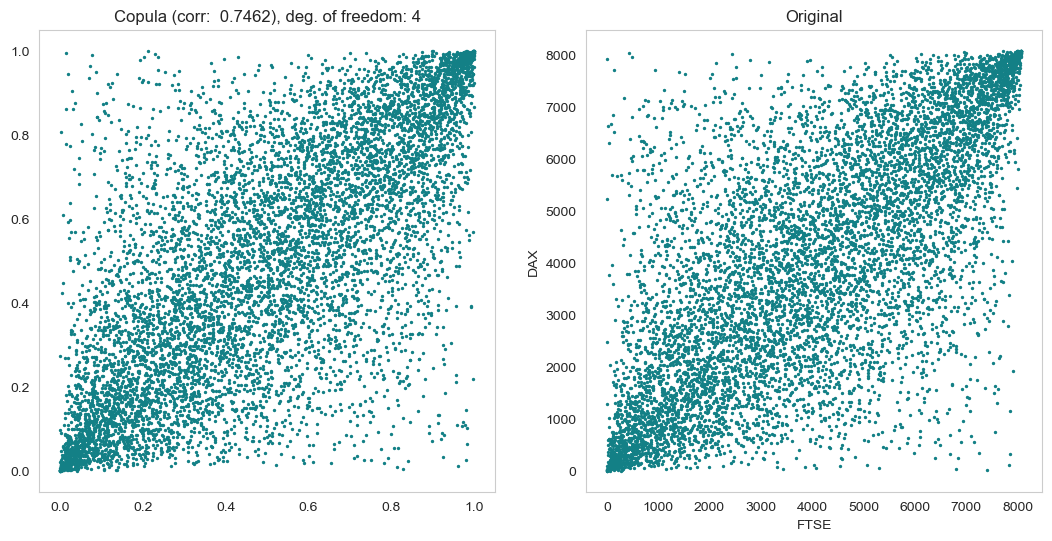

In [45]:
fig, axs = plt.subplots(ncols = 3, figsize = (20,6))
plot_copula(axs[0], axs[2], rho = 0.7461535931321613, deg_freedom=4)
plot_rankscatter(ftse, dax, axs[1], title = "Original")

In [46]:
data = losses_sync[["FTSE", "DAX"]].to_numpy()


from pycop import student, estimation

cop = student()
param, cmle = estimation.fit_cmle(cop, data)

In [47]:
param

array([0.999999  , 0.60447082])

In [48]:
from statsmodels.distributions.copula.api import (StudentTCopula)

cop = StudentTCopula()
cop.fit(data)

AttributeError: 'StudentTCopula' object has no attribute 'fit'

In [50]:
from pycopula import estimation
from pycopula.copula import StudentCopula

cop = StudentCopula()
estimation.mle(cop, data)

TypeError: mle() missing 2 required positional arguments: 'marginals' and 'hyper_param'